<h1>Train Simple Auto Encoder</h1>

<h3>Set up</h3>

In [74]:
!pip install datasets

import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torchvision.transforms as T

from datasets import load_dataset

np.random.seed(42)
torch.manual_seed(42)

mydata = load_dataset('valhalla/emoji-dataset')
keywords = ['face','christmas','superhero','supervillian','mage','vampire','monkey','elf','juggling',
            'boy','girl','adult','person','man','woman','male','female','worker','scientist','technologist',
            'singer','artist','pilot','astronaut','firefighter','police','sleuth','construction']

selected_images = []
selected_texts = []

# mydata['train'] ##['image', 'text'], # num_rows : 2749
for i in range(len(mydata['train'])):
    im = mydata['train'][i]['image']
    text = mydata['train'][i]['text'].lower()

    if any(kw in text for kw in keywords):

        im = im.resize((64, 64), Image.LANCZOS)
        arr = np.array(im, dtype=np.float32) / 255.0
        arr = np.transpose(arr, (2, 0, 1))
        selected_images.append(arr)
        selected_texts.append(text)

data = np.stack(selected_images)
x_q2 = torch.from_numpy(data)  # for later use (unshuffled data)



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


<h3>Conv Autoencoder</h3>

In [75]:
class ConvAutoencoder(nn.Module):
    def __init__(self, in_channels=3, latent_dim = 256*4*4):
        super().__init__()
        self.in_channels = in_channels

        # ------------- Encoder -------------
        self.encoder = nn.Sequential(
            # Input: (B, in_channels, 64, 64)
            nn.Conv2d(in_channels, 32, kernel_size=3, stride=2, padding=1),  # -> (B, 32, 32, 32)
            nn.ReLU(inplace=True),

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),           # -> (B, 64, 16, 16)
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),          # -> (B, 128, 8, 8)
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),         # -> (B, 256, 4, 4)
            nn.ReLU(inplace=True),
        )

        self.flatten = nn.Flatten()
        self.encoder_out_dim = 256 * 4 * 4

        # Optionally you can go from 256*4*4 to a smaller dense latent vector:
        self.fc_mu = nn.Linear(self.encoder_out_dim, latent_dim)
        self.fc_unflatten = nn.Linear(latent_dim, self.encoder_out_dim)


        # ------------- Decoder -------------
        self.decoder = nn.Sequential(
            # Start from (B, 256, 4, 4)
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),  # -> (B, 128, 8, 8)
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),   # -> (B, 64, 16, 16)
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),    # -> (B, 32, 32, 32)
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(32, in_channels, kernel_size=3, stride=2, padding=1, output_padding=1),   # -> (B, C, 64, 64)
            nn.Sigmoid() # assuming input images normalized to [0, 1]
        )

    def encode(self, x):
        x = self.encoder(x)            # (B, 256, 4, 4)
        x = self.flatten(x)            # (B, 256*4*4)
        z = self.fc_mu(x)              # (B, latent_dim)
        return z
    
    def decode(self, z):
        x = self.fc_unflatten(z)       # (B, 256*4*4)
        x = x.view(-1, 256, 4, 4)      # (B, 256, 4, 4)
        x = self.decoder(x)             # (B, C, 64, 64)
        return x
    
    def forward(self, x):
        z = self.encode(x)
        out = self.decode(z)
        return out

<h3>60/20/20 Split</h3>

In [76]:
x = torch.from_numpy(data)

# shuffle
N = x.shape[0]  # number of images
indices = torch.randperm(N)
x = x[indices]

n_train = int(0.6*N)
n_val = int(0.2*N)
n_test = N - n_train - n_val

x_train = x[:n_train]
x_val = x[n_train:n_train+n_val]
x_test = x[n_train+n_val:]

print("Train:", x_train.shape[0], "Val:", x_val.shape[0], "Test:", x_test.shape[0])

Train: 733 Val: 244 Test: 245


<h3>Data Augmentation</h3>

In [77]:
class EmojiDataset(Dataset):
    def __init__(self, data_tensor, transform=None):
        self.data = data_tensor
        self.transform = transform

    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        img = self.data[idx]
        if self.transform:
            img = self.transform(img)
        return img
    

train_transform = T.Compose([
    T.RandomHorizontalFlip(p=0.5)
])

train_ds = EmojiDataset(x_train, transform=train_transform)
val_ds = EmojiDataset(x_val, transform=None)
test_ds = EmojiDataset(x_test, transform=None)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=False)

In [79]:
device = torch.device("cpu")
print("Using device:", device)

latent_dim = 512
lr = 1e-3
model = ConvAutoencoder(in_channels=3, latent_dim=latent_dim).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

Using device: cpu


<h3>Learning Curve</h3>

In [80]:
num_epochs = 200

train_losses = []
val_losses = []

for epoch in range(num_epochs):

    ## train
    model.train()
    running_train = 0.0

    for batch in train_dl:
        images = batch.to(device)
        recon = model(images)
        loss = criterion(recon, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_train += loss.item() * images.size(0)

    epoch_train = running_train / len(train_ds)

    ## val
    model.eval()
    running_val = 0.0
    with torch.no_grad():
        for batch in val_dl:
            images = batch.to(device)
            recon = model(images)
            loss = criterion(recon, images)
            running_val += loss.item() * images.size(0)
        
    epoch_val = running_val / len(val_ds)

    train_losses.append(epoch_train)
    val_losses.append(epoch_val)

    print(f"Epoch [{epoch+1}/{num_epochs}] Train: {epoch_train:.4f} Val: {epoch_val: .4f}")


Epoch [1/200] Train: 0.1153 Val:  0.0796
Epoch [2/200] Train: 0.0751 Val:  0.0697
Epoch [3/200] Train: 0.0646 Val:  0.0609
Epoch [4/200] Train: 0.0576 Val:  0.0547
Epoch [5/200] Train: 0.0508 Val:  0.0475
Epoch [6/200] Train: 0.0437 Val:  0.0420
Epoch [7/200] Train: 0.0397 Val:  0.0396
Epoch [8/200] Train: 0.0365 Val:  0.0362
Epoch [9/200] Train: 0.0337 Val:  0.0340
Epoch [10/200] Train: 0.0313 Val:  0.0319
Epoch [11/200] Train: 0.0297 Val:  0.0310
Epoch [12/200] Train: 0.0278 Val:  0.0291
Epoch [13/200] Train: 0.0264 Val:  0.0282
Epoch [14/200] Train: 0.0249 Val:  0.0267
Epoch [15/200] Train: 0.0234 Val:  0.0253
Epoch [16/200] Train: 0.0223 Val:  0.0242
Epoch [17/200] Train: 0.0210 Val:  0.0237
Epoch [18/200] Train: 0.0202 Val:  0.0226
Epoch [19/200] Train: 0.0191 Val:  0.0215
Epoch [20/200] Train: 0.0180 Val:  0.0206
Epoch [21/200] Train: 0.0173 Val:  0.0197
Epoch [22/200] Train: 0.0168 Val:  0.0197
Epoch [23/200] Train: 0.0160 Val:  0.0188
Epoch [24/200] Train: 0.0154 Val:  0.0185
E

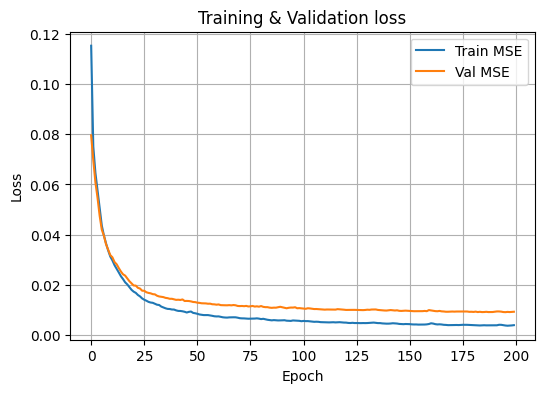

In [81]:
plt.figure(figsize=(6,4))
plt.plot(train_losses, label='Train MSE')
plt.plot(val_losses, label='Val MSE')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation loss')
plt.legend()
plt.grid(True)
plt.show()

In [82]:
model.eval()
test_running = 0.0
with torch.no_grad():
    for batch in test_dl:
        images = batch.to(device)
        recon = model(images)
        loss = criterion(recon, images)
        test_running += loss.item() * images.size(0)

test_mse = test_running / len(test_ds)
print("Final average test error:", test_mse)

Final average test error: 0.009235091530242745


<h3>5 side by side input and output images</h3>

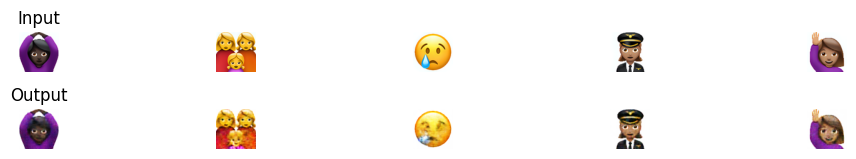

In [83]:
model.eval()

# small batch from the test set
test_batch = next(iter(test_dl))
test_batch = test_batch.to(device)
with torch.no_grad():
    out_batch = model(test_batch)

test_batch_np = test_batch.cpu().numpy()
out_batch_np = out_batch.cpu().numpy()

num_examples = 5
plt.figure(figsize=(10,4))

for i in range(num_examples):
    # input
    plt.subplot(5, num_examples, i+1)
    img = np.transpose(test_batch_np[i], (1, 2, 0))
    plt.imshow(img)
    plt.axis('off')
    if i == 0:
        plt.title("Input")

    # Output
    plt.subplot(5, num_examples, num_examples + i+1)
    img = np.transpose(out_batch_np[i], (1, 2, 0))
    plt.imshow(img)
    plt.axis('off')
    if i == 0:
        plt.title("Output")

plt.tight_layout()
plt.show()

<h2>Adding Features</h2>

In [84]:
def find_indices_with(substring):
    substring = substring.lower()
    return [i for i, txt in enumerate(selected_texts) if substring in txt]

print("Examples of 'face'", find_indices_with("face"))
print("Examples of 'smiling face'", find_indices_with("smiling face"))

Examples of 'face' [0, 1, 2, 3, 14, 25, 35, 41, 52, 63, 69, 79, 90, 101, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 188, 262, 334, 414, 465, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 488, 489, 494, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 529, 530, 535, 540, 541, 543, 544, 548, 552, 553, 554, 561, 562, 564, 570, 574, 578, 579, 580, 581, 582, 591, 602, 603, 614, 625, 636, 647, 658, 669, 680, 691, 702, 713, 714, 725, 736, 737, 738, 739, 740, 741, 742, 747, 756, 757, 758, 759, 760, 761, 762, 769, 776, 777, 778, 779, 780, 781, 782, 791, 802, 813, 824, 835, 846, 855, 856, 857, 858, 859, 860, 861, 862, 863, 864, 865, 866, 867, 868, 869, 870, 871, 872, 873, 874, 875, 884, 895, 906, 917, 928, 929, 940, 951, 962, 973, 984, 995, 1006, 1017, 1028, 1039, 1040, 1051, 1062, 1073, 1084, 109

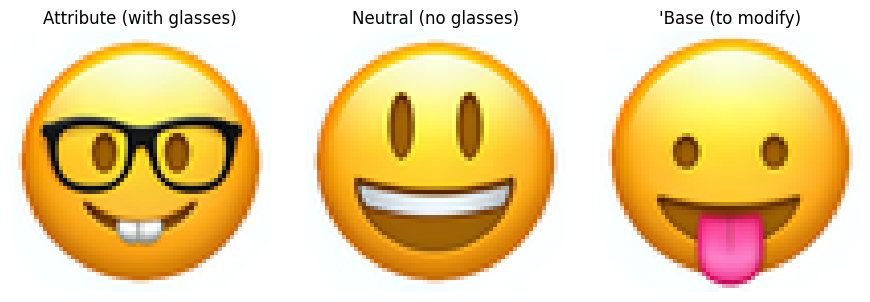

In [85]:
idx_attr = int(find_indices_with("nerd face")[0])
idx_neutral = int(find_indices_with("smiling face")[0])
idx_base = 540

plt.figure(figsize=(9,3))
for i, idx in enumerate([idx_attr, idx_neutral, idx_base]):
    plt.subplot(1, 3, i+1)
    plt.imshow(np.transpose(x_q2[idx].numpy(), (1, 2, 0)))
    plt.axis('off')
    if i == 0:
        plt.title("Attribute (with glasses)")
    elif i == 1:
        plt.title("Neutral (no glasses)")
    else: plt.title("'Base (to modify)")

plt.tight_layout()
plt.show()

<h3>Image Generation</h3>

In [86]:
upper_bound = 15
lower_bound = 512
alpha = 1.2

model.eval()

with torch.no_grad():
    img_attr = x_q2[idx_attr].unsqueeze(0).to(device)
    img_neutral = x_q2[idx_neutral].unsqueeze(0).to(device)
    img_base = x_q2[idx_base].unsqueeze(0).to(device)

    z_attr = model.encode(img_attr)
    z_neutral = model.encode(img_neutral)
    z_base = model.encode(img_base)

    attr_vector = z_attr - z_neutral
    flat_attr = attr_vector.flatten()
    upper = torch.zeros_like(flat_attr, dtype=torch.bool)
    upper[torch.topk(torch.abs(flat_attr), upper_bound).indices] = True

    lower = torch.zeros_like(flat_attr, dtype=torch.bool)
    lower[torch.topk(torch.abs(flat_attr), lower_bound).indices] = True

    mask = lower & ~upper
    flat_attr[~mask] = 0
    attr_vector = flat_attr.reshape(attr_vector.shape)

    z_new = z_base + alpha * attr_vector
    
    gen_img = model.decode(z_new)


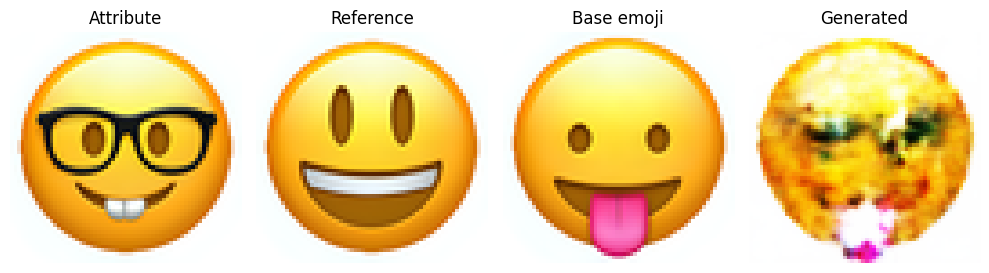

In [87]:
def tensor_to_img(t):
    if t.dim() == 4:
        t = t[0]

    img = t.detach().cpu().numpy()
    img = np.transpose(img, (1, 2, 0))
    # img = np.clip(img, 0, 1)
    return img

img_attr_np = tensor_to_img(img_attr)
img_neutral_np = tensor_to_img(img_neutral)
img_base_np = tensor_to_img(img_base)
gen_img_np = tensor_to_img(gen_img)

plt.figure(figsize=(10, 3))

plt.subplot(1, 4, 1)
plt.imshow(img_attr_np)
plt.axis('off')
plt.title("Attribute")

plt.subplot(1, 4, 2)
plt.imshow(img_neutral_np)
plt.axis('off')
plt.title("Reference")

plt.subplot(1, 4, 3)
plt.imshow(img_base_np)
plt.axis('off')
plt.title("Base emoji")

plt.subplot(1, 4, 4)
plt.imshow(gen_img_np)
plt.axis('off')
plt.title("Generated")

plt.tight_layout()
plt.show()